In [132]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.decomposition import PCA, SparsePCA, TruncatedSVD
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE
import plotly.graph_objects as go

from adjustText import adjust_text
import matplotlib
from sklearn.preprocessing import KBinsDiscretizer

plt.rcParams['figure.facecolor'] = 'white'

In [14]:

df = pd.read_csv("C:/Users/TS/PycharmProjects/DS1-RecommendationSystems/data.csv")
pivot = pd.pivot_table(df, index='subreddit', columns='user', values='count', fill_value=0, aggfunc=lambda x: 1)  #
# df['count'] = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile').fit_transform(df[['count']])
# df['count'].hist()

In [15]:
item_to_idx = {item: idx for idx, item in enumerate(pivot.index)}
idx_to_item = {idx: item for idx, item in enumerate(pivot.index)}

user_to_idx = {item: idx for idx, item in enumerate(pivot.columns)}
idx_to_user = {idx: item for idx, item in enumerate(pivot.columns)}

items_user = csr_matrix(pivot.values)  # A matrix of shape (number_of_items, number_of_users).

In [16]:
subreddit_group = df.groupby(by=['subreddit'])['count']
sum_comments_per_subreddit = subreddit_group.sum().reset_index(name="total_num_comments")
subreddit_summary = sum_comments_per_subreddit.sort_values(by='total_num_comments', ascending=False, ignore_index=True)
subreddit_summary = subreddit_summary.iloc[:10]

In [17]:
layout = go.Layout(margin=dict(l=10, r=10, t=10, b=10),
                   yaxis=dict(title="Total number of comments"),
                   yaxis2={'title': 'Number unique users', 'overlaying': 'y', 'side': 'right'})
fig = go.Figure(layout=layout)
fig.add_trace(go.Bar(x=subreddit_summary['subreddit'], opacity=1, name="Number of comments",
                     y=subreddit_summary['total_num_comments'], orientation='v', offsetgroup=1,
                     yaxis='y'))
fig.write_image("resources/subreddit_overview_small.png")


In [19]:
pca = PCA(n_components=50).fit_transform(items_user.todense())

In [20]:
pca_sparse = TruncatedSVD(n_components=50).fit_transform(items_user.todense())

In [26]:
tsne = TSNE(n_components=2, perplexity=10, n_jobs=-1).fit_transform(pca_sparse)


In [100]:
gaussian_mixture = GaussianMixture(n_components=60)
gaussian_mixture.fit(tsne)
gaussian_mixture_c = gaussian_mixture.predict(tsne)

agglomerative = AgglomerativeClustering(n_clusters=None, distance_threshold=95).fit(tsne)
print(agglomerative.n_clusters_)



41


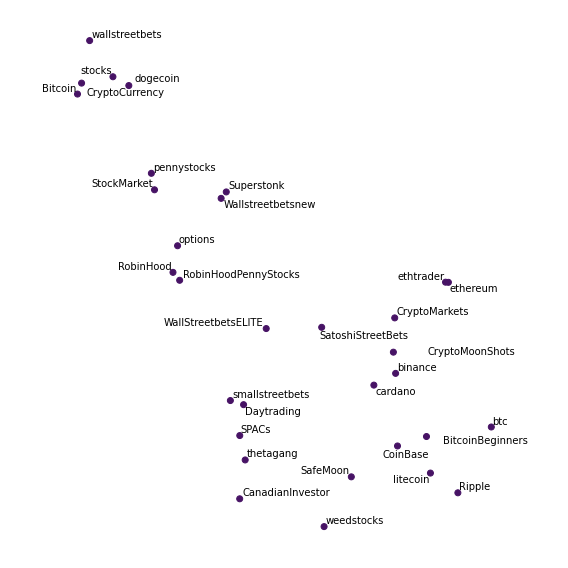

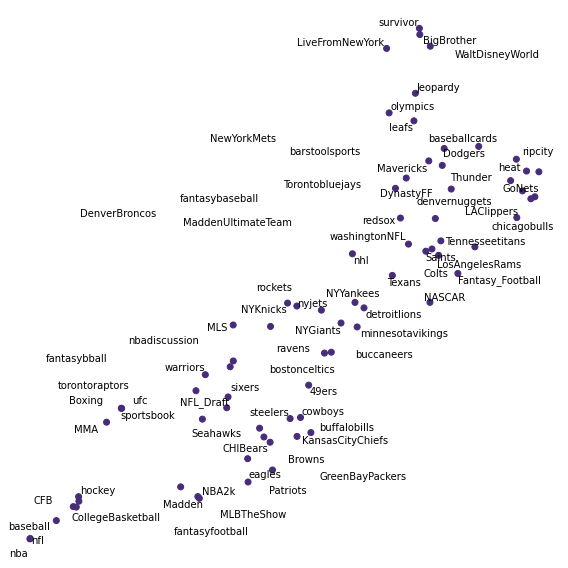

In [141]:
cmap = matplotlib.cm.get_cmap('viridis')

def zoom_cluster(c, subreddit=None):
    if subreddit is not None:
        subreddit_idx = item_to_idx[subreddit]
        c = agglomerative.labels_[subreddit_idx]

    idx = np.where(agglomerative.labels_ == c)
    cluster_data = tsne[idx]
    tol = 1
    x0, y0 = np.min(cluster_data, axis=0) - tol
    x1, y1 = np.max(cluster_data, axis=0) + tol

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))


    ax.scatter(cluster_data[:, 0], cluster_data[:, 1], alpha=1, color=cmap(((5 * agglomerative.labels_[idx]) % agglomerative.n_clusters_ ) / agglomerative.n_clusters_))
    ax.axis([x0, x1, y0, y1])
    ax.axis("off")

    annot = []
    for i, txt in enumerate(np.array(list(item_to_idx.keys()))[idx]):
         annot.append(ax.text(cluster_data[:, 0][i], cluster_data[:, 1][i], txt))

    adjust_text(annot)

    plt.tight_layout()
    plt.savefig(f"resources/clustering_{subreddit}.png", dpi=400)
    plt.show()

zoom_cluster(1, subreddit="wallstreetbets")
zoom_cluster(1, subreddit="nba")

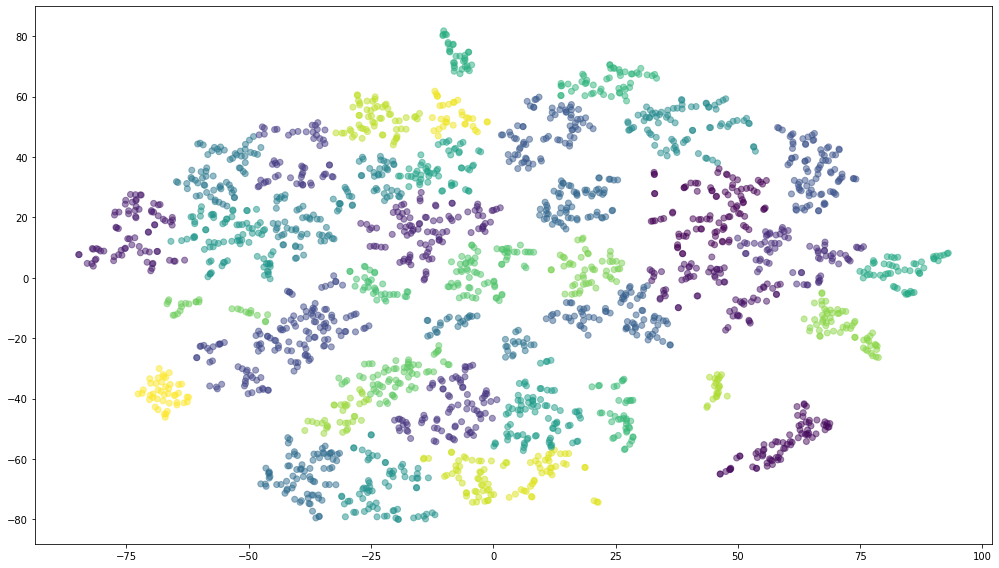

In [140]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 8))
ax.scatter(tsne[:, 0], tsne[:, 1], alpha=0.5, c=agglomerative.labels_)
plt.tight_layout()
plt.savefig("resources/clustering_subreddits.png", dpi=400)
plt.show()

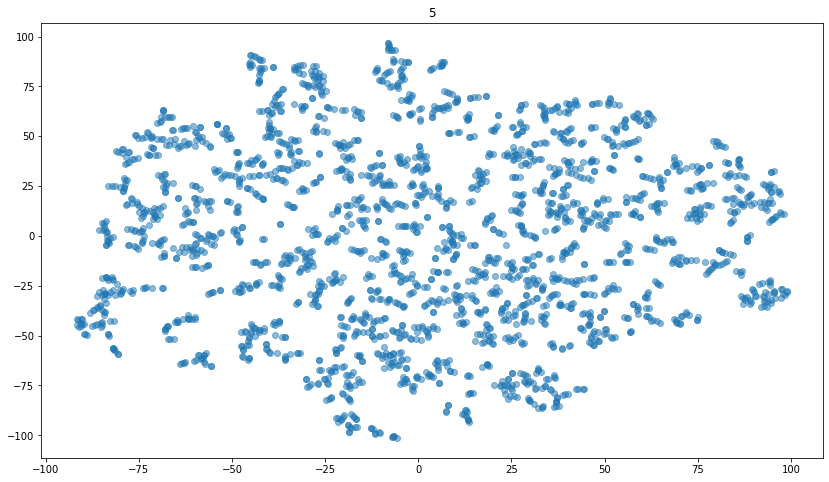

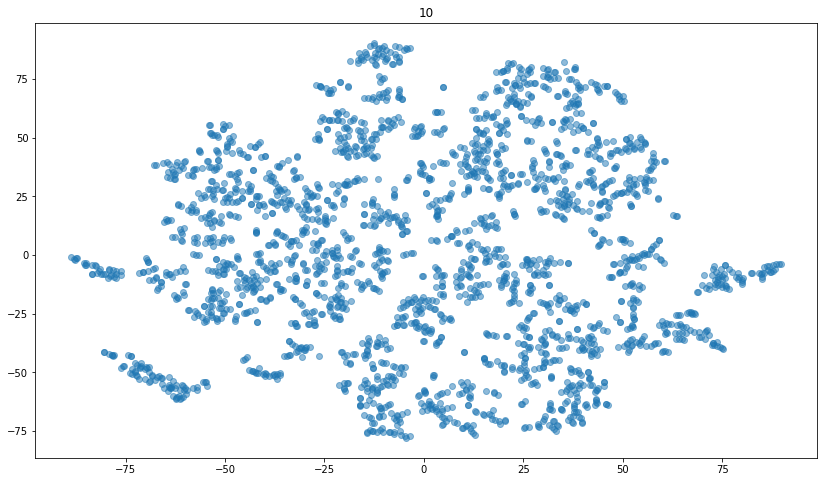

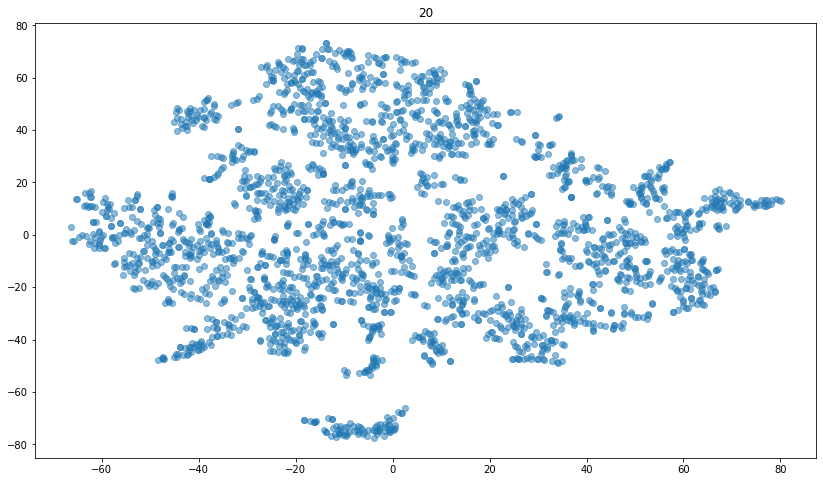

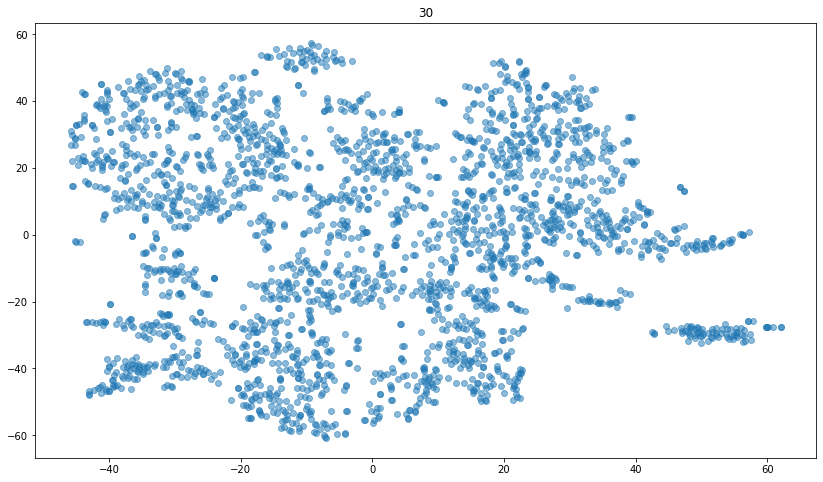

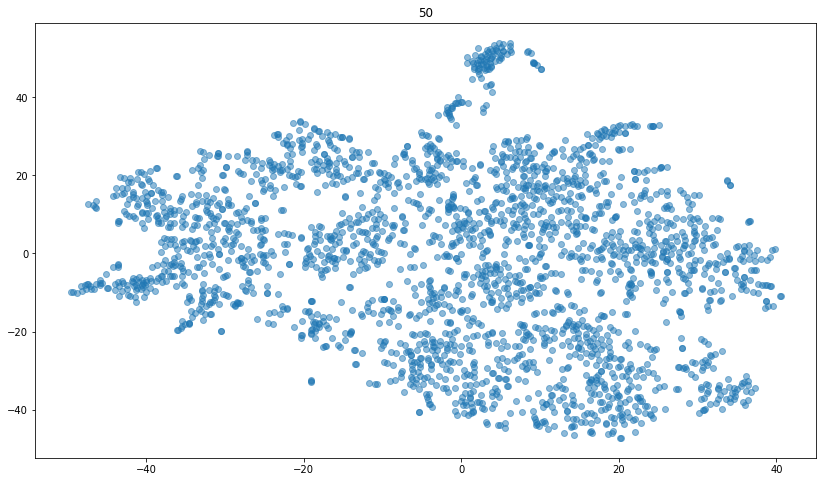

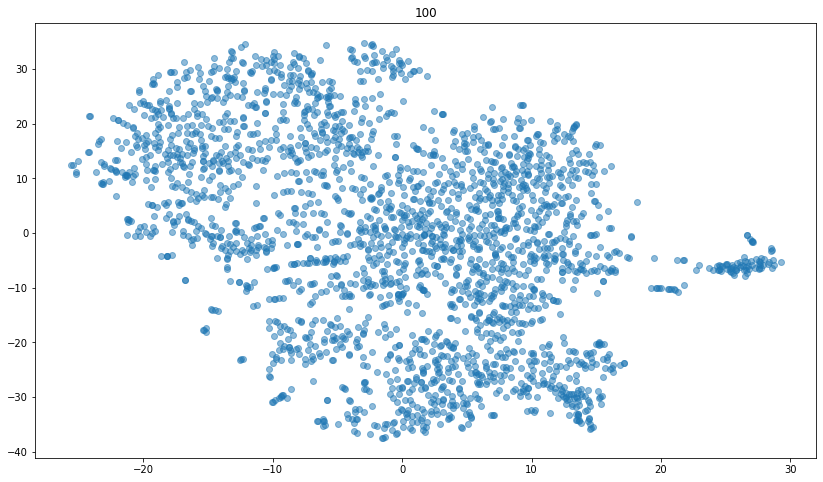

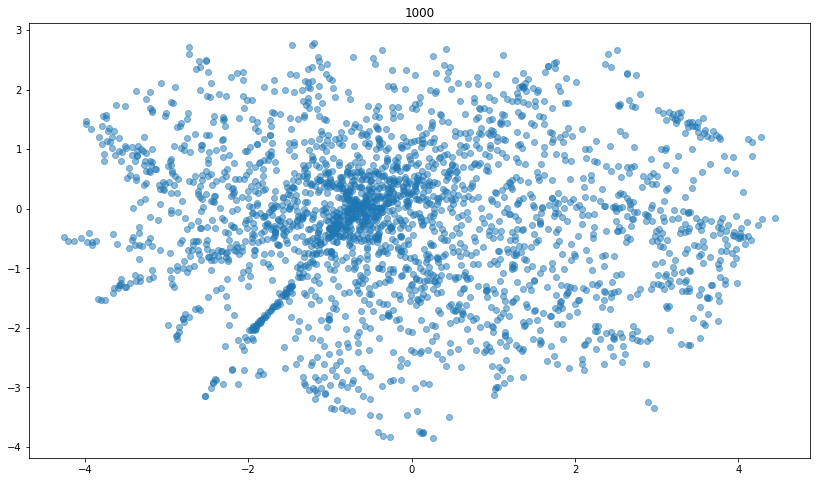

In [24]:
for i in [5, 10, 20, 30, 50, 100, 1000]:
    tsne = TSNE(n_components=2, perplexity=i, n_jobs=-1).fit_transform(pca_sparse)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 8))
    ax.scatter(tsne[:, 0], tsne[:, 1], alpha=0.5)
    ax.set_title(f"{i}")
    plt.show()


In [32]:
layout = go.Layout(margin=dict(l=10, r=10, t=10, b=10), width=2000,height=2000)
fig = go.Figure(layout=layout)
fig.add_trace(go.Scatter(
    x=tsne[:, 0],
    y=tsne[:, 1],
    mode="markers+text",
    name="Lines, Markers and Text",
    text=list(item_to_idx.keys()),
    textposition="top center",
    marker=dict(color=gaussian_mixture_c),
))
fig.update_layout(font=dict(
    size=8,
    color="Black"
))
